## Additional Notebook to the Project C9!

This notebook used for visualise the barchart of dog breed count for poster and additionally, train one more model, which is Model 3. We will see how to use Keras and TensorFlow to build, train, and test a Convolutional Neural Network capable of identifying the breed of a dog in a supplied image.

In [2]:
import numpy as np          
import pandas as pd     
from random import randint
from numpy import asarray #to make img into arra
import cv2
import matplotlib.pyplot as plt

In [4]:
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [6]:
df_train = pd.read_csv("labels.csv")
df_train.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Visualisation of Top 20 dog breeds by count

Inspired by reference #1 (Reference section in the end of the notebook!).

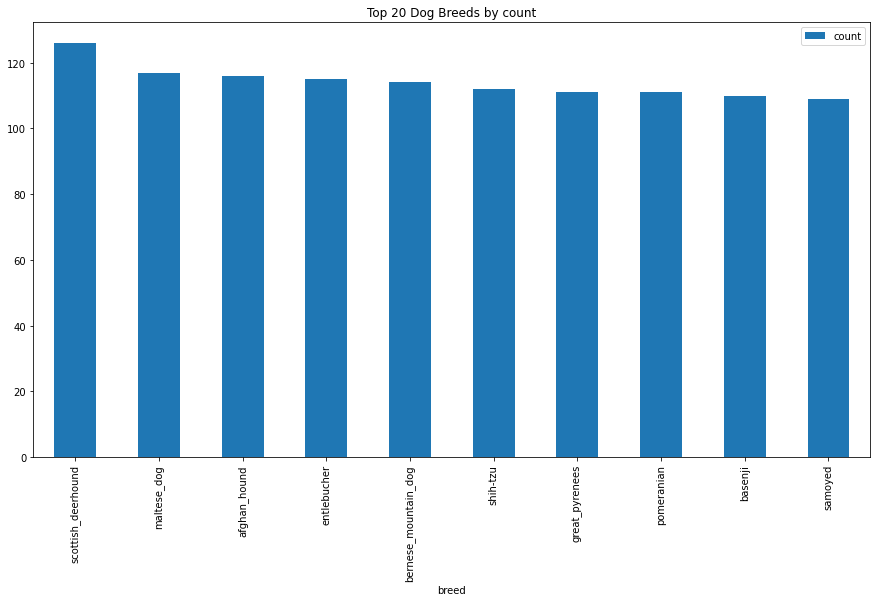

In [7]:
df_train.groupby('breed')['breed'] \
    .count() \
    .reset_index(name='count') \
    .sort_values(by = 'count',ascending=False) \
    .head(10) \
    .plot.bar(x = 'breed',y = 'count',figsize=(15,8))
plt.title('Top 20 Dog Breeds by count')
plt.show()


In [9]:
img_width=290
img_height=290
images=[]
classes=[]
#load training images
for f, breed in (df_train.values):
    img = cv2.imread('train/{}.jpg'.format(f))
    classes.append(breed)
    images.append(cv2.resize(img, (img_width, img_height)))

In [10]:
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = df_train[(df_train['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


Some of the code below was taken from Hamed Etezadi's notebook for one hot encoding and normalization. See references #2!

In [11]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in range(len(labels)):
    img = image.load_img('../input/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = asarray(img) #this needs to be an array
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0
    
# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


### Building the classification model : Model 3
In this model, we won't use any pre-trained layers or architecture, but we build our own. The motivation behind this, came from one of the notebooks, we came across in the research stage. See reference #2 (Reference section in the end of the notebook!)

In [13]:
# Building the Model, Sequential was chosen after looking online
#how different models work, we chose this and are experimenting with parameters.
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 32)      18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 16)        25104     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 8)         3208      
__________

In [15]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

Now we are going to train this model, I am using epochs 50-60 and experimenting with different variables

In [18]:
# Training the model
epochs = 60
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Train on 256 samples, validate on 65 samples
Epoch 1/60
256/256 [==============================] - 47s 185ms/step - loss: 4.2679 - acc: 0.5820 - val_loss: 4.2517 - val_acc: 0.5692
Epoch 2/60
256/256 [==============================] - 48s 186ms/step - loss: 4.2282 - acc: 0.6133 - val_loss: 4.2138 - val_acc: 0.6308
Epoch 3/60
256/256 [==============================] - 47s 185ms/step - loss: 4.1898 - acc: 0.6758 - val_loss: 4.1723 - val_acc: 0.6462
Epoch 4/60
256/256 [==============================] - 47s 185ms/step - loss: 4.1471 - acc: 0.6953 - val_loss: 4.1263 - val_acc: 0.6769
Epoch 5/60
256/256 [==============================] - 47s 185ms/step - loss: 4.1019 - acc: 0.6875 - val_loss: 4.0788 - val_acc: 0.7231
Epoch 6/60
256/256 [==============================] - 48s 186ms/step - loss: 4.0540 - acc: 0.6914 - val_loss: 4.0358 - val_acc: 0.6154
Epoch 7/60
256/256 [==============================] - 48s 186ms/step - loss: 4.0031 - acc: 0.7031 - val_loss: 3.9828 - val_acc: 0.6769
Epoch 8/60

### Predicting Model 3 on test data

In [19]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set:', round((score[1]*100), 2), '%')

36/36 [==============================] - 3s 76ms/step
Accuracy over the test set: 61.11 %


# Referenes
1. https://www.kaggle.com/code/methindor/dogbreeddatavisualisation
2. https://www.kaggle.com/code/hamedetezadi/cnn-model-dog-breed-identification-ngos